In [77]:
import numpy as np
from matplotlib import pyplot as plt, collections
from scipy.spatial import ConvexHull

In [121]:
seed = 12
np.random.seed(seed)
X = np.random.uniform(0, 1, (20, 2))
V = np.c_[X, (X**2).sum(axis=1)[:,None]]

In [122]:
ch = ConvexHull(V)
valid = np.where(np.dot(ch.equations[:,0:3], [0, 0, -1]) > 0.00001)[0]

In [173]:
def plot_regular_triangulation(ch, valid, ax=None, **kwargs):
    """Plot the regular triangulation.
    
    :param ch: Convex Hull (as returned by `scipy.spatial.ConvexHull`.)
    :param ax: the Axes instance to plot to, if left emtpy, a new figure
    is created.
    :return: None
    """
    x = ch.points[:,0]
    y = ch.points[:,1]
    t = ch.simplices[valid]

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.set_aspect('equal')
    ax.triplot(x, y, t, **kwargs)
    ax.scatter(x, y)

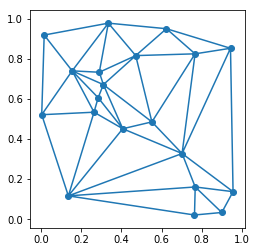

In [174]:
plot_regular_triangulation(ch, valid)

In [175]:
def all_edges(ch, valid):
    """List all edges in the convex hull."""
    nb = np.zeros(shape=(len(valid), 2*ch.ndim), dtype=int)
    nb[:,1::2] = ch.neighbors[valid]  # neighbours index into simplices and equations
    nb[:,0::2] = valid[:,None]        # so does `valid`, we intersperse them to create pairs
    return np.unique(np.sort(nb.reshape([-1, 2]), axis=1), axis=0)

def finite_edges(ch, valid):
    edges = all_edges(ch, valid)
    finite = np.isin(edges, valid).sum(axis=1) == 2
    return edges, finite

def edge_points(ch, edges):
    """Compute the dual vertices for all edges."""
    save = np.seterr(invalid = 'ignore', divide = 'ignore')
    pts = - ch.equations[:,:2] / ch.equations[:,2][:,None] / 2
    np.seterr(**save)
    return pts[edges]

def infinite_ray(ch, edge, valid):
    if edge[0] in valid and edge[1] not in valid:
        f0 = edge[0]
        f1 = edge[1]
    elif edge[1] in valid and edge[0] not in valid:
        f0 = edge[1]
        f1 = edge[0]
    else:
        raise ValueError("Edge should have precisely one simplex in valid.")
        
    v = [i for i in ch.simplices[f0] if i in ch.simplices[f1]]
    assert len(v) == 2
    v0 = ch.points[v[0]]
    v1 = ch.points[v[1]]
    centre = ch.points[ch.simplices[f0]].sum(axis=0) / 3
    if np.cross(v0 - centre, v1 - centre)[2] > 0:
        x = v1 - v0
    else:
        x = v0 - v1
    d = np.array([x[1], -x[0]])
    d /= np.sqrt(x[0]**2 + x[1]**2)
    return -ch.equations[f0, :2] / ch.equations[f0, 2] / 2, d

In [176]:
edges, finite = finite_edges(ch, valid)

In [195]:
from matplotlib import patches

In [276]:
def plot_power_diagram(ch, valid, ax=None, inf_scale=10, linewidth=1.0, **kwargs):
    """Plot the power diagram."""
    edges, finite = finite_edges(ch, valid)
    m_edge_points = edge_points(ch, edges[finite])
    lc_grid = collections.LineCollection(m_edge_points, linewidth=1.2, **kwargs)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    inf_rays = np.array([infinite_ray(ch, edge, valid) for edge in edges[~finite]])
    inf_edges = inf_rays.copy()
    inf_edges[:,1,:] += inf_edges[:,0,:]
    inf_dotted = collections.LineCollection(inf_edges, linestyle='dashed', zorder=10, color='black', linewidth=0.8)
    inf_arrows = [patches.FancyArrow(inf_rays[i,0,0], inf_rays[i,0,1], inf_rays[i,1,0]/10, inf_rays[i,1,1]/10,
                                     color='black', width=0.000, head_width=0.01)
                  for i in range(len(inf_rays))]
    inf_coll = collections.PatchCollection(inf_arrows, color='black', linewidth=linewidth)

    ax.add_collection(lc_grid)
    ax.add_collection(inf_dotted)
    ax.add_collection(inf_coll)

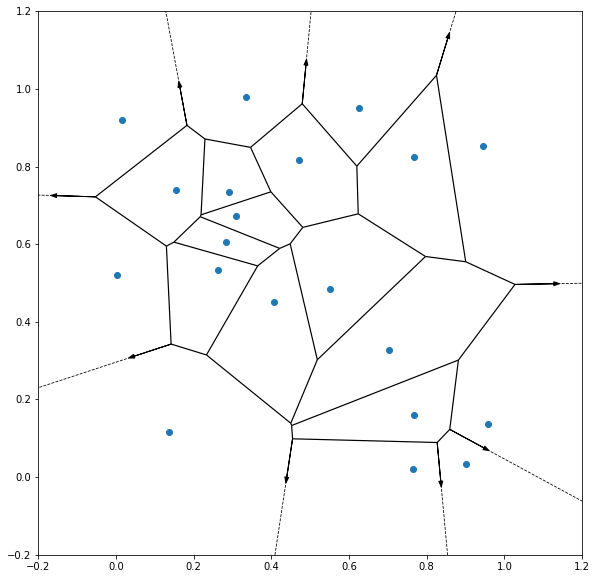

In [277]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={ 'aspect': 1.0 })
# plot_regular_triangulation(ch, valid, ax, color='#cccccc', zorder=1)
ax.scatter(ch.points[:,0], ch.points[:,1])
plot_power_diagram(ch, valid, ax, color='black', zorder=10, linewidth=1.0)
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)
plt.show()